In [194]:
#helper functions 
from tqdm import tqdm

def generate_n_colours(n):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(n)]


# Discussion Questions

1. Using the hash table performance formulas given in the chapter, compute the average number of comparisons necessary when the table is

10% full

25% full

50% full

75% full

90% full

99% full

At what point do you think the hash table is too small? Explain.


In [2]:
#formulas for open addressing with linear probing --
#successful: 1/2 * (1 + 1/(1 - lambda))
#unsuccessful: 1/2 * (1 + 1/(1 - lambda)**2)
lambdas = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
for l in lambdas:
    print(f'lambda = {l}')
    print(f'successful: {1/2 * (1 + 1/(1 - l) )}')
    print(f'unsuccessful: {1/2 * (1 + 1/(1 - l)**2 )}')


lambda = 0.1
successful: 1.0555555555555556
unsuccessful: 1.117283950617284
lambda = 0.25
successful: 1.1666666666666665
unsuccessful: 1.3888888888888888
lambda = 0.5
successful: 1.5
unsuccessful: 2.5
lambda = 0.75
successful: 2.5
unsuccessful: 8.5
lambda = 0.9
successful: 5.500000000000001
unsuccessful: 50.50000000000003
lambda = 0.99
successful: 50.49999999999996
unsuccessful: 5000.499999999991


Judging from the results, I think when lambda is at 0.75 the hash table is too small. Although during successful searches the average number of comparisons is 2.5, which is still acceptable even for small number of inputs, but the increase in average number of comparisons for unsuccessful searches to 8.5 would mean that for small number of inputs, sequential search or binary search may be more efficient in these cases. 

In [3]:
#2. Modify the hash function for strings to use positional weightings.
def hash_str_positional(a_string, table_size):
    return sum([ord(c)*(i+1) for i,c in enumerate(a_string)]) % table_size

table_size = 5
print(hash_str_positional('cat', table_size))
print(hash_str_positional('tac', table_size))
print(hash_str_positional('act', table_size))

1
2
3


In [4]:
# 3. We used a hash function for strings that weighted the characters by position. 
# Devise an alternative weighting scheme. What are the biases that exist with these functions?

def hash_str_alt(a_string, table_size, p):
    #another weighting scheme is polynomial rolling hash 
    return sum([ord(c)* (p)**(i) for i,c in enumerate(a_string)]) % table_size

table_size = 11
p = 31
# https://cp-algorithms.com/string/string-hashing.html
# p should be a prime number roughly equal to the numbero f characters in the input alphabet - 
# e.g. if input is only lowercase letters of eng alphabet, p=31 is good choice. If upper + lower, then 53 is a possible choice.
# choice of m i.e. table_size should be a large number since probability of two random strings colliding is ~ 1/m 
 
print(hash_str_alt('cat', table_size, p))
print(hash_str_alt('tac', table_size, p))
print(hash_str_alt('act', table_size, p))

6
10
0


In [5]:
# 4. Research perfect hash functions. Using a list of names (classmates, family members, etc.), 
# generate the hash values using the perfect hash algorithm.

"""
Universal Hash (dynamic data): expected constant time for insertion, deletion and search. Choose hash function randomly 
from some set of hash functions (universal hash family). 

Perfect hash function (static data): function that maps set of actual key values to table without any collisons

Minimal perfert hash function: function that maps keys to a table that has only as many slots as therea are key values to be hashed,
without any collisions.

Dynamic perfect hashing: hash function that update themselves when the original set is modified 

k-perfect hashing: hash functions where at most k elements from original set are mapped onto same value in the range. 
"""

#https://www.cs.cmu.edu/~avrim/451f11/lectures/lect1004.pdf
#https://www.youtube.com/watch?v=z0lJ2k0sl1g&ab_channel=MITOpenCourseWare

def get_letter_frequencies(string_set):
    #for each word, get first and last letter and determine freqs of those letters
    letters = {}
    for word in string_set:
        for idx in [0, -1]:
            if word[idx] in letters:
                letters[word[idx]] += 1 
            else:
                letters.update({word[idx]: 1})
    return letters

def score_words(string_set, letter_frequencies):
    scores = []
    for word in string_set:
        scores.append(letter_frequencies[word[0]] + letter_frequencies[word[-1]])
    return scores 

class G:
    def __init__(self, letter, from_word, i):
        self.letter = letter 
        self.from_word = from_word 
        self.val = 0
        self.i = i
    
    def reset_val(self):
        self.val = 0
    
    def is_from_word(self, word):
        return word == self.from_word 
    
    def __add__(self, integer):
        self.val += 1

    def __repr__(self):
        return f'G(letter={self.letter}, from_word={self.from_word}, val={self.val})'
    
def add_g(i, word, gs):
    curr_gs = [g.letter for g in gs]
    if word[0] not in curr_gs:
        gs.append(G(word[0], word, i))
    if word[-1] not in curr_gs and word[-1] != word[0]:
        gs.append(G(word[-1], word, i))
    return gs

def calc_h(word, gs, m):
    g1 = [g.val for g in gs if g.letter == word[0]]
    assert len(g1) == 1
    g1 = g1[0]
    g2 = [g.val for g in gs if g.letter == word[-1]]
    assert len(g2) == 1
    g2 = g2[0]
    return (len(word) + g1 + g2) % m

def g_search(sorted_set, max_steps=5):
    m = len(sorted_set) #table size 
    #get all first and last letters 
    gs = []
    i = 0 #track i word
    table = [None] * m
    while -1 < i < m:
        #rollback 
        #print(table)
        rollback = False
        word = sorted_set[i]
        curr_gs = [g for g in gs[-2:] if g.from_word == word]
        if len(curr_gs) == 1:
            if curr_gs[0].val == max_steps:
                #print(f'rollback 1 {word}')
                if word in table:
                    table[table.index(word)] = None
                gs.pop()
                #roll back to previous word that had an entry
                i = sorted_set.index(gs[-1].from_word)
                rollback = True 
            
        elif len(curr_gs) == 2:
            if curr_gs[1].val == max_steps:
                #print(f'rollback 2 {word}')
                if word in table:
                    table[table.index(word)] = None
                for _ in range(2):
                    gs.pop()
                #roll back to previous word that had an entry
                i = sorted_set.index(gs[-1].from_word)
                rollback = True
                
        if rollback:
            continue   

        gs = add_g(i, word, gs)
        h = calc_h(word, gs, m)
        if table[h] is None:
            #print(f'set {word} at {h}')
            if word in table:
                table[table.index(word)] = None
            table[h] = word 
            i += 1
        else:
            curr_gs = [g for g in gs[-2:] if g.from_word == word]
            if len(curr_gs) == 0:
                #print(f'empty g: {word} roll back at {h}')
                #return to previous word that had a g entry
                i = sorted_set.index(gs[-1].from_word)

            elif len(curr_gs) == 1:
                #print(f'inc 1 {word} i {i}')
                curr_gs[0].val += 1
            elif len(curr_gs) == 2:
                if curr_gs[0].val < max_steps:
                    #print(f'inc j=0 {word} i {i}')
                    curr_gs[0].val += 1
                else:
                    #print(f'inc j=1 {word} i {i}')
                    curr_gs[1].val += 1

    assert len(set(table)) == len(table)              
    return gs

def cichellis(string_set, max_steps=5):
    freqs = get_letter_frequencies(string_set)
    scores = score_words(string_set, freqs)
    sorted_set = [word for _, word in sorted(zip(scores, string_set), reverse=True)]
    #print(sorted_set)
    #returns function g 
    gs = g_search(sorted_set, max_steps=max_steps)
    solution = {}
    for word in string_set:
        solution.update({word: calc_h(word, gs, len(string_set))})
    print(solution)

tests = [['kib', 'mib', 'lib', 'nib', 'pib', 'doglion', 'fishcat', 'hib', 'turts', 'squib'],

        ['euterpe', 'calliope', 'erato', 'terpsichore', 'melpomene', 'thalia', 'clio', 'polyhymnia', 'urania'],

        ['get', 'text', 'reset', 'output', 'maxint', 'input', 'true', 'integer', 'eof', 'rewrite',
        'false', 'chr', 'char', 'trunc', 'real', 'sqr']]
for test in tests:
    cichellis(test, max_steps=len(test))

{'kib': 8, 'mib': 6, 'lib': 7, 'nib': 3, 'pib': 4, 'doglion': 1, 'fishcat': 2, 'hib': 9, 'turts': 0, 'squib': 5}
{'euterpe': 7, 'calliope': 8, 'erato': 5, 'terpsichore': 2, 'melpomene': 0, 'thalia': 6, 'clio': 4, 'polyhymnia': 3, 'urania': 1}
{'get': 4, 'text': 6, 'reset': 13, 'output': 14, 'maxint': 15, 'input': 8, 'true': 9, 'integer': 0, 'eof': 3, 'rewrite': 2, 'false': 5, 'chr': 11, 'char': 12, 'trunc': 7, 'real': 1, 'sqr': 10}


In [211]:
import random
import statistics

def bubble_sort(lst):
    for i in range(len(lst)-1, 0, -1):
        exchanges = False
        for j in range(1, i+1):
            if lst[j-1] > lst[j]:
                exchanges = True 
                lst[j], lst[j-1] = lst[j-1], lst[j]

        if not exchanges:
            #bubble sort short - terminates if list is sorted
            break
    return lst

def selection_sort(lst):
    for i in range(len(lst)-1, 0, -1):
        max_i = 0
        for j in range(1, i+1):
            if lst[j] > lst[max_i]:
                max_i = j
        lst[i], lst[max_i] = lst[max_i], lst[i]
    return lst  

def insertion_sort(lst):
    for i in range(1, len(lst)):
        curr_val = lst[i]
        curr_pos = i
        while curr_pos > 0:
            #compare to previous value 
            if curr_val < lst[curr_pos-1]:
                #prev value greater, so shift value to right 
                lst[curr_pos] = lst[curr_pos-1]
            elif curr_val >= lst[curr_pos-1]:
                #found the correct position
                break 
            curr_pos -= 1
        lst[curr_pos] = curr_val 
    return lst 
            
def sublist_sort(lst, start_pos, gap_size):
    pos = list(range(start_pos, len(lst), gap_size))
    #then just insertion sort for sublist 
    for i in range(1, len(pos)):
        curr_val = lst[pos[i]]
        curr_i = i
        while curr_i > 0:
            if curr_val < lst[pos[curr_i-1]]:
                lst[pos[curr_i]] = lst[pos[curr_i-1]]
            elif curr_val >= lst[pos[curr_i-1]]:
                break
            curr_i -= 1
        lst[pos[curr_i]] = curr_val 
    return lst 

def shell_sort(lst):
    n_sublists = len(lst)//2
    while n_sublists > 0:
        for start in range(n_sublists):
            lst = sublist_sort(lst, start, n_sublists)
        n_sublists = n_sublists//2
    return lst 
    

def merge_sort(lst):
    if len(lst) == 1:
        return lst
    else:
        #call mergesort on left and right half 
        left_half = merge_sort(lst[:len(lst)//2])
        right_half = merge_sort(lst[len(lst)//2:])

        #merge step 
        i = 0 #left half pointer 
        j = 0 #right half pointer 
        k = 0 #lst pointer 

        while i < len(left_half) and j < len(right_half):
            if left_half[i] >= right_half[j]:
                lst[k] = right_half[j]
                j += 1
            else:
                lst[k] = left_half[i]
                i += 1
            k += 1

        #fill rest of list with left half or right half 
        while i < len(left_half):
            lst[k] = left_half[i]
            i += 1
            k += 1
        
        while j < len(right_half):
            lst[k] = right_half[j]
            j += 1
            k += 1
        
        return lst

def partition(lst, first, last, method='random'):
    assert method in ['random', 'first', 'last', 'median']
    if method == 'random':
        #pivot point will be element chosen at random 
        pivot = random.choice(range(first, last+1))
        #place pivot at start of list just to make things neater 
        if pivot != first:
            lst[first], lst[pivot] = lst[pivot], lst[first]
    elif method == 'first':
        #do nothing
        pass
    elif method == 'last':
        #swap first and last elements
        lst[first], lst[last] = lst[last], lst[first]
    elif method == 'median':
        #uses median of three
        middle = (first+last)//2
        choices = [lst[first], lst[middle], lst[last]]
        median = statistics.median(choices)
        median_idx = choices.index(median)
        if median_idx == 1:
            lst[middle], lst[first] = lst[first], lst[middle]
        elif median_idx == 2:
            lst[last], lst[first] = lst[first], lst[last]
        
    i = first + 1
    j = last
    while True:
        # i <= j conditional has to come FIRST!! 
        # or else when i > j and j is last will run into error
        while i <= j and lst[i] <= lst[first]:
            i += 1

        while i <= j and lst[j] >= lst[first]:
            j -= 1
        
        if i > j:
            break
        else:
            #swap and keep moving i and j 
            lst[i], lst[j] = lst[j], lst[i]

        
    lst[j], lst[first] = lst[first], lst[j]
    return j


def quicksorter(lst, first, last, method='random'):
    if first < last:
        pivot = partition(lst, first, last, method=method)
        quicksorter(lst, first, pivot-1, method=method)
        quicksorter(lst, pivot+1, last, method=method)
        return lst

def quick_sort(lst, method='random'):
    return quicksorter(lst, 0, len(lst)-1, method=method)
    


In [204]:
# 5. Generate a random list of integers. Show how this list is sorted by the following algorithms:
# bubble sort, selection sort, insertion sort, shell sort (you decide on increments),
# merge sort, quick sort (you decide on pivot value)

# 6. Consider the following list of integers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# 7. Consider the following list of integers: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# 8. Consider the list of characters: ["P", "Y", "T", "H", "O", "N"]

#just going to test the algorithms using the different test cases provided 

import random

methods = [bubble_sort, selection_sort, shell_sort, merge_sort, quick_sort]

for method in methods:
    test_cases = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ,
                [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
                ["P", "Y", "T", "H", "O", "N"],
                [random.randint(0, 100) for _ in range(10)]]

    for test in test_cases:
        if method(test) != sorted(test):
            print(f'{method.__name__} failed {test}')


Devise alternative strategies for choosing the pivot value in quick sort. 
For example, pick the middle item. Re-implement the algorithm and then execute it on random data sets. 
Under what criteria does your new strategy perform better or worse than the strategy from this chapter?


alternative strategies: 
    - choosing final element: performance should be similar to choosing first element, unless median elements are clustered at the 
    tail of the list 
    - choosing middle element: performance will be better when list is sorted, as it will preserve the log(n) partitions in
    those cases 
    - random pivot: low probability of the worst case of O(n^2) when bad pivots are chosen!

# Programming exercises

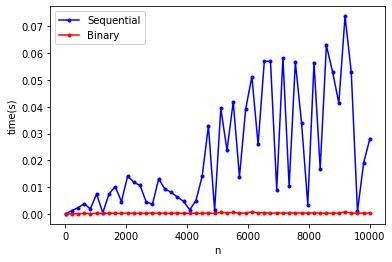

In [8]:
# 1. Set up a random experiment to test the difference between a sequential search and a binary search on a list of integers
from timeit import Timer
import matplotlib.pyplot as plt
import numpy as np 

def sequential_search(lst, item):
    for i in range(len(lst)):
        if lst[i] == item:
            return True
    return None 

def binary_search(lst, item):
    left = 0
    right = len(lst)-1
    while left <= right:
        middle = (left + right)//2 
        if lst[middle] == item:
            return True 
        elif lst[middle] < item:
            left = middle + 1
        elif lst[middle] > item:
            right = middle - 1
    return None 

X = []
Y1 = [] #sequential
Y2 = [] #binary
number = 1_00
for size in np.linspace(10, 100_00):
    size = int(size)
    x = [random.randint(0, size) for _ in range(size)]
    y = random.randint(0, size//2)
    t1 = Timer(f"sequential_search(x, y)", "from __main__ import x, y, sequential_search")
    t2 = Timer(f"binary_search(x, y)", "from __main__ import x, y, binary_search")
    X.append(size)
    Y1.append(t1.timeit(number=number))
    Y2.append(t2.timeit(number=number))


plt.plot(X, Y1, color='blue', marker='.', label='Sequential')
plt.plot(X, Y2, color='red', marker='.', label='Binary')


plt.xlabel('n')
plt.ylabel('time(s)')
plt.legend()


Generally speaking, sequential search's run time increased linearly with the increase of n, whilst binary search's search time increase is much slower (log(n) complexity worse case). The run time is not perfectly linear for sequential because there could be cases where the target element is located near the head of the list, and so the function can be terminated early once the element is found.

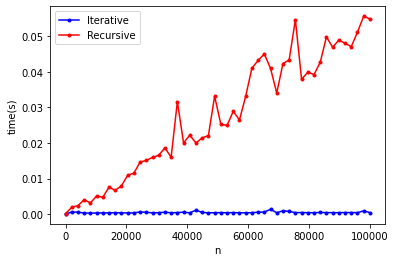

In [9]:
# 2. Use the binary search functions given in the text (recursive and iterative). Generate a random, 
# ordered list of integers and do a benchmark analysis for each one. What are your results? Can you explain them?
def recursive_slicing_main(lst, item):
    left = 0 
    right = len(lst) - 1
    if left <= right:
        middle = (left + right) // 2 
        if lst[middle] == item:
            return True 
        elif lst[middle] < item:
            return recursive_slicing_main(lst[middle+1:], item)
        elif lst[middle] > item:
            return recursive_slicing_main(lst[:middle], item)
    return None 

def binary_search_recursive_slicing(lst, item):
    return recursive_slicing_main(lst, item)

X = []
Y1 = [] #iterative
Y2 = [] #recursive
number = 1_00
for size in np.linspace(10, 100_000):
    size = int(size)
    x = [random.randint(0, size) for _ in range(size)]
    y = random.randint(0, size//2)
    t1 = Timer(f"binary_search(x, y)", "from __main__ import x, y, binary_search")
    t2 = Timer(f"binary_search_recursive_slicing(x, y)", "from __main__ import x, y, binary_search_recursive_slicing")
    X.append(size)
    Y1.append(t1.timeit(number=number))
    Y2.append(t2.timeit(number=number))


plt.plot(X, Y1, color='blue', marker='.', label='Iterative')
plt.plot(X, Y2, color='red', marker='.', label='Recursive')


plt.xlabel('n')
plt.ylabel('time(s)')
plt.legend()
    

Across the different input sizes, generally speaking iterative binary search is quicker than that of recursive binary search. This may be because calling functions within python involves creating creating new stack frames, which is likely to be more costly than simply running a while loop. Also, in the above implementation of recursive binary search slicing is involved which is an O(K) operation where K is the size of the slice. The could also add to the run time of the algorithm.

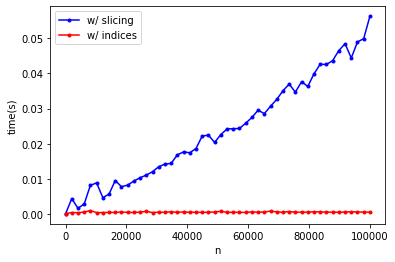

In [10]:
# 3. Implement the binary search using recursion without the slice operator. 
# Recall that you will need to pass the list along with the starting and ending index values for the sublist. 
# Generate a random, ordered list of integers and do a benchmark analysis.

def recursive_indices_main(lst, item, left, right):
    if left <= right:
        middle = (left + right) // 2 
        if lst[middle] == item:
            return middle 
        elif lst[middle] < item:
            return recursive_indices_main(lst, item, middle+1, right)
        elif lst[middle] > item:
            return recursive_indices_main(lst, item, left, middle-1)
    return None 

def binary_search_recursive_indices(lst, item):
    return recursive_indices_main(lst, item, 0, len(lst)-1)

X = []
Y1 = [] #slicing
Y2 = [] #indices
number = 1_00
for size in np.linspace(10, 100_000):
    size = int(size)
    x = [random.randint(0, size) for _ in range(size)]
    y = random.randint(0, size//2)
    t1 = Timer(f"binary_search_recursive_slicing(x, y)", "from __main__ import x, y, binary_search_recursive_slicing")
    t2 = Timer(f"binary_search_recursive_indices(x, y)", "from __main__ import x, y, binary_search_recursive_indices")
    X.append(size)
    Y1.append(t1.timeit(number=number))
    Y2.append(t2.timeit(number=number))


plt.plot(X, Y1, color='blue', marker='.', label='w/ slicing')
plt.plot(X, Y2, color='red', marker='.', label='w/ indices')


plt.xlabel('n')
plt.ylabel('time(s)')
plt.legend()


Comparing run times across different ns, binary search with slicing in general is more costly and so takes additional runtime comapred to binary search without slicing. This experiment demonstrates the additional cost involved with O(K) slicing especially as n increases, as K would also increase proportionally.

In [11]:
# 4. Implement the len method (__len__) for the hash table Map ADT implementation.

# 5. Implement the in method (__contains__) for the hash table Map ADT implementation.

# 6. Implement the method (__del__) for the hash table Map ADT implementation.

# 7. In the hash table map implementation, the hash table size was chosen to be 101. 
# If the table gets full, this needs to be increased. Re-implement the put method so that the table will automatically 
# resize itself when the loading factor reaches a predetermined value 
# (you can decide the value based on your assessment of load versus performance).

# 8. Implement quadratic probing as a rehash technique.



from pythonds3 import HashTable
from typing import Any

class ModHashTable(HashTable):
    def __init__(self, *args, max_lambda=0.75, factor=2, quadratic_probing=False, compression=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.del_marker = 'DELETE'
        self.max_lambda = max_lambda
        self.factor = factor
        self.quadratic_probing = quadratic_probing
        if quadratic_probing:
            self._rehash = self.quadratic_probing
            assert compression == False 

        #self._probes stores the number of probes needed to store an item i.e. the number of hashes required to place item
        self._probes = [0] * self._size
        self.compression = compression
        if self.compression:
            self.del_marker = None 

    def __len__(self):
        #HashTable uses open addressing so simply need to check how many slots are occupied 
        return len([i for i in self._slots if type(i) == int])

    def __contains__(self, key):
        #in the github repo of the package the __contains__ method is simply 
        #return key in self._slots
        #which is fine, but below is more specific to hashtables that use open addressing, which is used in the 
        #parent class
        hash_value = self._hash_function(key, len(self._slots))
        if self._slots[hash_value] is None:
            return False 
        else:
            if self._slots[hash_value] == key:
                return True 
            else:
                #if slot is occupied and != key, then search rest of slots b/c open addressing
                j = 0
                next_slot = self._rehash(hash_value, len(self._slots), j)
                while (
                self._slots[next_slot] is not None 
                and self._slots[next_slot] != key
                and j < self._size):
                    j += 1
                    next_slot = self._rehash(hash_value, len(self._slots), j)
                
                if j == self._size:
                    return False 
                else:
                    return self._slots[next_slot] == key

    def put(self, key: int, data: Any, resize=True) -> None:
        """Add an item to the table - modified to recognize deletion key as free slot as well, and automatically
        readjust table size when max_lambda reached"""
        hash_value = self._hash_function(key, len(self._slots))

        if self._slots[hash_value] in [None, self.del_marker]:
            self._slots[hash_value] = key
            self._data[hash_value] = data
            self._probes[hash_value] = 1
        else:
            if self._slots[hash_value] == key:
                self._data[hash_value] = data  # replace
            else:
                j = 0
                next_slot = self._rehash(hash_value, len(self._slots), j)
                while (
                    self._slots[next_slot] not in [None, self.del_marker]
                    and self._slots[next_slot] != key
                    and j < self._size
                ):
                    j = j + 1
                    next_slot = self._rehash(hash_value, len(self._slots), j)

                if self._slots[next_slot] in [None, self.del_marker]:
                    self._slots[next_slot] = key
                    self._data[next_slot] = data
                    #store number of probes 
                    self._probes[next_slot] = j + 1
                elif j == self._size:
                    raise MemoryError("Hash Table is full")
                else:
                    self._data[next_slot] = data  # replace

        #assess load factor here, and see if need to expand/reduce slots 
        if resize:
            curr_lambda = len(self)/self._size
            if curr_lambda > self.max_lambda:
                self.resize(self.factor)
        
    def resize(self, factor):
        print(f'resizing by factor of {factor}')
        #automatic resize of the table according to a predetermined factor 
        new_size = int(self._size * factor) #b/c we're using +1 linear probing, don't need to use a prime number 
        old_slots = self._slots  
        old_data = self._data 
        #initialise new slots, data and probes
        self._slots = [None] * new_size 
        self._data = [None] * new_size
        self._probes = [None] * new_size
        for i, key in enumerate(old_slots):
            if key is not None:
                self.put(key, old_data[i], resize=False)

        self._size = new_size


    def __delitem__(self, key):
        #this is called lazy deletion
        hash_value = self._hash_function(key, len(self._slots))
        if self._slots[hash_value] is None:
            #key does not exist in here!
            return False 
        else:
            if self._slots[hash_value] == key:
                #remove key and data - mark slot with deletion key
                self._slots[hash_value] = self.del_marker
                self._data[hash_value] = None 
                if self.compression:
                    self.linear_compress(hash_value)
            else:
                #go into probing sequence to find key
                j = 0
                next_slot = self._rehash(hash_value, len(self._slots), j)
                while (
                    self._slots[next_slot] is not None
                    and self._slots[next_slot] != key 
                    and j < self._size
                ):
                    j += 1
                    next_slot = self._rehash(hash_value, len(self._slots), j)
                
                if self._slots[next_slot] is None:
                    #key does not exist
                    return False
                elif j == self._size:
                    #searched all slots and key not found
                    return False 
                else:
                    #key found
                    self._slots[next_slot] = self.del_marker
                    self._data[next_slot] = None
                    if self.compression:
                        self.linear_compress(next_slot)


    def linear_compress(self, i):
        """
        https://upcommons.upc.edu/bitstream/handle/2117/122770/Jimenez.pdf;jsessionid=B5010B56042F189470605C580E7CF454?sequence=1
        __delitem__ itself causes problems (also called lazy deletion), where if there are lots of deletions, the 
        remaining tombstones will cause search for certain items to be slow, even if the list is largely empty, as the 
        probe sequence from when the list is still full is kept in tact. To combat this, at every removal we can 
        compress the implicit linked lists within the table, thereby maintaining efficiency. This particular compress method
        is only suitable for linear probing, but another implementation of is illustrated in the link above for other types of
        open addressing.
        """
        free = i
        next_slot = self._rehash(i, len(self._slots), 1)
        p = 1
        while self._probes[next_slot] != 0:
            if self._probes[next_slot] > p:
                self._slots[free], self._slots[next_slot] = self._slots[next_slot], self._slots[free]
                self._data[free], self._data[next_slot] = self._data[next_slot], self._data[free]
                self._probes[free] = self._probes[next_slot] - p
                self._probes[next_slot] = 0
                free = next_slot 
                p = 0
            next_slot = self._rehash(next_slot, len(self._slots), 1)
            p += 1

    def quadratic_probing(self, old_hash: int, size: int, step: int):
        return (old_hash + step**2) % size





##### 6. How can you delete items from a hash table that uses chaining for collision resolution? How about if open addressing is used? What are the special circumstances that must be handled? Implement the del method for the HashTable class.


If hash table uses chaining for collision resolution, in a deletion we can first navigate to the query key's hash_value,
we then traverse the linked list stored at that slot, and remove an element as we would in a normal linked list.
If open addressing is used, then we would again navigate to query key's hash_value. If the key exists in the initial location,
we will remove the element. However, if a different key is found, we will rehash the hash_value to find the next possible location.
This step is repeated until the key is found, which in the worse case requires traversal of the whole list. 


A special circumstance that must be handled in open addressing is illustrated in the following example:
(https://stackoverflow.com/questions/9127207/hash-table-why-deletion-is-difficult-in-open-addressing-scheme):
<br>
<br>
`
hash(x) = hash(y) = hash(z)
`
<br>
<br>
In an open addressing scheme, we would get:
<br>
<br>
`
    table[i] = x, table[i+1] = y, table[i+2] = z
`
<br>
<br>
In this scenario, if we deleted x from the table, if we later want to search for y or z, we will find that:
<br>
<br>
`
    hash(z) = i, and table[i] = None
`
<br>
<br>
And we would not be able to find y and z, as it would seem as if they do not exist in the table. 
To overcome this, we need to set table[i] with a special marker (e.g. 'DELETED') to indicate to the search function 
to keep searching, because y and z may still be in the table.
<br>
^ this is almost like keeping an implicit linked list within the table, where elements with the same probe sequence
are searched/added/deleted from this implicit list. Deleting an earlier element therefore is equal to destroying a linked list! 
<br>
^ in a poor scenario, where many elements have the same probe sequence, but there have been a lot of subsequent deletions 
within this list, we will be left with a very empty list (but filled with 'DELETED'), but search will remain costly, because 
of all the deletion marks



In [12]:
#Test hash table 
a = ModHashTable(quadratic_probing=False, max_lambda=0.5)
print(f'size {a._size}')
a.put(75, '75')
a.put(91, '91')
a.put(107, '107')
print(a._slots)
del a[75]
print(a._slots)
#check that probe sequence is not broken
print(91 in a)
print(107 in a)

#try resizing 
for i in range(107, 107 + (11 * 16), 16):
    a.put(i, str(i))

print(a._slots)
print(a._size)


size 16
[None, None, None, None, None, None, None, None, None, None, None, 75, 91, 107, None, None]
[None, None, None, None, None, None, None, None, None, None, None, 'DELETE', 91, 107, None, None]
True
True
resizing by factor of 2
[251, None, None, None, None, None, None, None, None, None, None, 171, 203, 107, 139, 235, 267, None, None, None, None, None, None, None, None, None, None, 155, 187, 91, 123, 219]
32


In [13]:
#Test compression deletion 
b = ModHashTable(quadratic_probing=False, compression=True, max_lambda=0.5)
b.put(0, '0')
b.put(16, '16')
b.put(32, '32')
b.put(48, '48')
b.put(19, '19')
print(b._slots)
print(b._probes)
del b[16]
del b[48]
print(b._slots)
print(b._probes)
print(48 in b)
print(19 in b)
b.put(18, '18')
print(b._slots)
print(b._probes)
del b[0]
del b[18]
print(b._slots)
print(b._probes)



[0, 16, 32, 48, 19, None, None, None, None, None, None, None, None, None, None, None]
[1, 2, 3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 32, None, 19, None, None, None, None, None, None, None, None, None, None, None, None]
[1, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
False
True
[0, 32, 18, 19, None, None, None, None, None, None, None, None, None, None, None, None]
[1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[32, None, None, 19, None, None, None, None, None, None, None, None, None, None, None, None]
[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


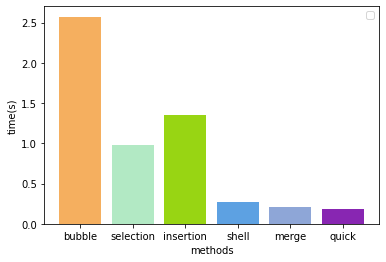

In [205]:
# 9. Using a random number generator, create a list of 500 integers. 
# Perform a benchmark analysis using some of the sorting algorithms from this chapter. 
# What is the difference in execution speed?
import copy

X = []
sorts = ['bubble_sort', 'selection_sort', 'insertion_sort', 'shell_sort', 'merge_sort', 'quick_sort']
Y = []
for _ in range(len(sorts)):
    Y.append([])
number = 1_00
size = int(500)
x = [random.randint(0, size) for _ in range(size)]
for i,sort in enumerate(sorts):
    t = Timer(f"{sort}(copy.deepcopy(x))", f"from __main__ import copy, x, {sort}, size")
    Y[i].append(t.timeit(number=number))
X.append(size)


colours = generate_n_colours(len(sorts))

for i, (sort, colour) in enumerate(zip(sorts, colours)):
    plt.bar(sort.split('_')[0], Y[i], color=colour)


plt.xlabel('methods')
plt.ylabel('time(s)')
plt.legend()


Bubble sort exhibits the worse performance, as there are the a lot of redundant comparisons and substitutions in each pass. Selection sort being an improved version of bubble sort showed much better performance, where in each pass only one substitution is done. Insertion sort was slightly worse than selection sort, perhaps because the the random list had many small elements towards the tail of the list, so there were more comparisons and shifts needed to place them in the correct location. Shell, merge and quick sort all showed similar performance, where the execution time is a fraction of the former three. Shell sort in particular was surprising, given it's a modified version of insertion sort. But during the sublist sort it gives smaller elements the opportunity to travel down the list quicker, reducing the number of comparisons and shifts required greatly. Merge sort is expected to demonstrate great performance, given the worse case O(n) is always nlogn, and because the list isn't that big, memory wasn't a factor in hindering performance. Quick sort also showed great performance, as this implementation randomly chooses a pivot such that the average case performance will be nlogn, meaning good pivots were chosen generally, and the worse case O(n^2) was not encountered.

In [15]:
"""
10. A bubble sort can be modified to “bubble” in both directions. The first pass moves “up” the list, 
and the second pass moves “down.” This alternating pattern continues until no more passes are necessary. 
Implement this variation and describe under what circumstances it might be appropriate.
"""

def bubble_sort_bidirectional(lst):
    i = len(lst)-1
    j = 0
    while j < i:
        exchanges = False
        for k in range(1, i+1):
            if lst[k-1] > lst[k]:
                exchanges = True 
                lst[k], lst[k-1] = lst[k-1], lst[k]
        i -= 1

        for k in range(i, j, -1):
            if lst[k] < lst[k-1]:
                exchanges = True 
                lst[k], lst[k-1] = lst[k-1], lst[k]
        j += 1
        if not exchanges:
            break

    return lst



In [139]:
test_cases = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ,
            [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
            ["P", "Y", "T", "H", "O", "N"],
            [random.randint(0, 100) for _ in range(100)]]

for test in test_cases:
    if bubble_sort_bidirectional(test) != sorted(test):
        print(f'failed {test}')

Bidirectional bubble sort (aka. cocktail sort/shaker sort), is more appropriate when elements are close to their sorted locations, and is generally faster than plain bubble sort. A scenario that illustrates this is when the list is partially sorted (e.g. [2,3,4,5,1]), if plain bubble sort is used it would take four passes for the list to be sorted, whereas it would only take one pass for bidirectional sort to sort the list. (another way of thinking about it is that an element at the end of the list can only move back by one each pass in plain bubble sort, whereas bidirectional sort offers a path to the head of the list quickly.)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


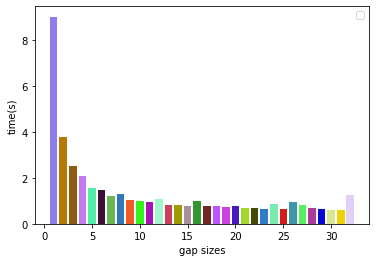

In [17]:
"""
11. Perform a benchmark analysis for a shell sort, using different increment sets on the same list.
"""

def shell_sort_static(lst, gap_size):
    while gap_size > 0:
        for start in range(gap_size):
            lst = sublist_sort(lst, start, gap_size)
        gap_size = gap_size//2
    return lst 

X = []
gaps = range(1, 32+1)
Y = []
for _ in range(len(gaps)):
    Y.append([])
number = 1_00
size = int(1000)
x = [random.randint(0, size) for _ in range(size)]
for i,gap in enumerate(gaps):
    t = Timer(f"shell_sort_static(copy.deepcopy(x), gap)", f"from __main__ import copy, x, shell_sort_static, gap")
    Y[i].append(t.timeit(number=number))
X.append(size)

colours = generate_n_colours(len(gaps))

for i, (gap, colour) in enumerate(zip(gaps, colours)):
    plt.bar(gap, Y[i], color=colour)


plt.xlabel('gap sizes')
plt.ylabel('time(s)')
plt.legend()


From the results, as the gap size increased, there was also performance increase. Even a gap size of 2 compared to gap size of 1 (which is ordinary insertion sort) yielded great performance boost. This is because a greater gap size allows elements to traverse further down the list with fewer comparisons and shifts. However, as the gap size increased to around 15, the performance of the sorting flattened. This may be because at higher gap sizes although elements can travel further, there is also a tradeoff where more sublist sorts have to be performed in the process as there are greater gap sizes that are visited, leading to performance plateau. There are other ways to select the decrementing gap sizes (e.g. 2<sup>k</sup> - 1 sequence, or Successive numbers of the form 2<sup>p</sup>3<sup>q</sup> - current implementation only doing simple n/2 sequence from an initial defined gap size, which is modified from len(lst)/2 original implementation) which can avoid the worse case time complexity of O(n<sup>2</sup>) of the current implementation.

In [135]:
"""
12. Implement the merge_sort function without using the slice operator.
"""

def merge_sort_indexing(lst):
    return merge_indexing_main(lst, 0, len(lst))

def merge_indexing_main(lst, left, right):
    #right-left is better than left < right -- infinite recursion occurs when left and right are adjacent,
    #b/c middle will always be left!
    if right - left > 1:
        #call mergesort on left and right half 
        middle = (left+right)//2
        
        #inplace operations so
        merge_indexing_main(lst, left, middle)
        merge_indexing_main(lst, middle, right)
        
        #merge step 
        i = left #left half pointer 
        j = middle #right half pointer 
        k = left #lst pointer 

        temp = []
        # while loop < than means they will never reach middle and right
        while i < middle and j < right:
            if lst[i] >= lst[j]:
                temp.append(lst[j])
                j += 1
            else:
                temp.append(lst[i])
                i += 1
            k += 1

        #fill rest of list with left half or right half 
        if i == middle:
            temp += lst[j:right]
        elif j == right:
            temp += lst[i:middle]
        
        #replace slice
        lst[left:right] = temp
        return lst


In [138]:
test_cases = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ,
            [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
            ["P", "Y", "T", "H", "O", "N"],
            [random.randint(0, 100) for _ in range(100)]]

for test in test_cases:
    if merge_sort_indexing(test) != sorted(test):
        print(f'failed {test}')

In [206]:
"""
13. One way to improve the quick sort is to use an insertion sort on lists that have a small length (call it the “partition limit”). 
Why does this make sense? Re-implement the quick sort and use it to sort a random list of integers. 
Perform an analysis using different list sizes for the partition limit.
"""

def quicksorter_limit(lst, first, last, partition_limit):
    if first < last:
        if last - first <= partition_limit:
            sorted_sublist = insertion_sort(lst[first:last+1])
            lst[first:last+1] = sorted_sublist
            return lst
        
        else:
            pivot = partition(lst, first, last, method='random')
            quicksorter_limit(lst, first, pivot-1, partition_limit)
            quicksorter_limit(lst, pivot+1, last, partition_limit)
            return lst

def quick_sort_limit(lst, partition_limit=10):
    return quicksorter_limit(lst, 0, len(lst)-1, partition_limit)


In [207]:
test_cases = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ,
            [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
            ["P", "Y", "T", "H", "O", "N"],
            [random.randint(0, 100) for _ in range(100)]]

for test in test_cases:
    if quick_sort_limit(test) != sorted(test):
        print(f'failed {test}')

In shorter lists sorting algorithms such as insertion sort uses fewer comparisons and swaps compared to quicksort. Quicksort is only a lot more efficient with large lists. Another sorting algorithm such as selection sort can also be used in hybrid with quick sort to achieve better efficiency.

16it [00:04,  3.63it/s]


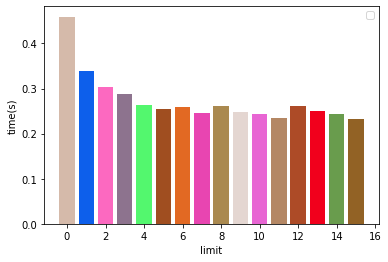

In [209]:
X = []
size = int(100)
limits = range(15+1)
Y = []
for _ in range(len(limits)):
    Y.append([])
number = 1_000
x = [random.randint(0, size) for _ in range(size)]
for i,limit in tqdm(enumerate(limits)):
    t = Timer(f"quick_sort_limit(copy.deepcopy(x), limit)", f"from __main__ import copy, x, quick_sort_limit, limit")
    Y[i].append(t.timeit(number=number))
X.append(size)

colours = generate_n_colours(len(limits))

for i, (limit, colour) in enumerate(zip(limits, colours)):
    plt.bar(limit, Y[i], color=colour)


plt.xlabel('limit')
plt.ylabel('time(s)')
plt.legend()


Here, we experiment with quick_sort_limit on a list of 100 numbers. The list is deliberately kept small, so that the effects of the partition limit can be more easily seen (in large lists the dominant operations will be the usual quicksort, so later small insertion sorts will have negligible effect). Here, 0 limit is plain quick sort. In comparison, we can see that even when limit=1, the use of quicksort can lead to much more efficient performance. There is an outlier at 12 and 13 where execution time is suddenly comparable to pure quick_sort, but that may be due to other factors as at 14 and 15 the performance returns. Up to limit=15, we have still yet to see the inflection point at which the increased use of insertion sort leads to worse performance, indicating that the choice of the partition limit can be quite robust and not too sensitive within this range.

4it [00:26,  6.52s/it]


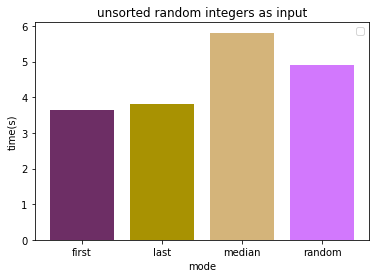

In [220]:
"""
14. Implement the median-of-three method for selecting a pivot value as a modification to quick_sort. 
Run an experiment to compare the two techniques.
"""

X = []
size = int(1000)
modes = ['first', 'last', 'median', 'random']
Y = []
for _ in range(len(modes)):
    Y.append([])
number = 1_000
for i,mode in tqdm(enumerate(modes)):
    for n in range(number):
        x = [random.randint(0, size) for _ in range(size)]
        t = Timer(f"quick_sort(x, mode)", f"from __main__ import copy, x, quick_sort, mode")
        if len(Y[i]) == 0:
            Y[i].append(t.timeit(number=1))
        else:
            Y[i][0] += t.timeit(number=1)
X.append(size)

colours = generate_n_colours(len(modes))

for i, (mode, colour) in enumerate(zip(modes, colours)):
    plt.bar(mode, Y[i], color=colour)

plt.title('unsorted random integers as input')
plt.xlabel('mode')
plt.ylabel('time(s)')
plt.legend()




4it [02:22, 35.52s/it]


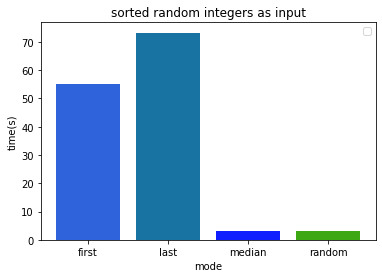

In [221]:
X = []
modes = ['first', 'last', 'median', 'random']
Y = []
for _ in range(len(modes)):
    Y.append([])
for i,mode in tqdm(enumerate(modes)):
    for n in range(number):
        x = sorted([random.randint(0, size) for _ in range(size)])
        t = Timer(f"quick_sort(x, mode)", f"from __main__ import copy, x, quick_sort, mode")
        if len(Y[i]) == 0:
            Y[i].append(t.timeit(number=1))
        else:
            Y[i][0] += t.timeit(number=1)
X.append(size)

colours = generate_n_colours(len(modes))

for i, (mode, colour) in enumerate(zip(modes, colours)):
    plt.bar(mode, Y[i], color=colour)

plt.title('sorted random integers as input')
plt.xlabel('mode')
plt.ylabel('time(s)')
plt.legend()

The first experiments compares the respective pivot selection methods on unsorted random integers. In this scenario, all methods show comparative performance, where median and random show slowly poorer performance, possibly due to the extra computations involved in selecting median and random values. In the second experiment comparing performance on a sorted list, we see that median-of-three and random pivot selections are able to avoid the worse case O(n<sup>2</sup>), but still being able to select optimal pivot values. In comparison, selecting first or final value as pivot in this experiment leads to very poor run time.